In [19]:
# Required Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.impute import SimpleImputer

# 1) Load data, display column names and dataset size
# Load the dataset
df = pd.read_csv('/content/ad_click_dataset.csv')

# Display column names and dataset size
print("Column Names:", df.columns)
print("Dataset Size:", df.shape)

Column Names: Index(['id', 'full_name', 'age', 'gender', 'device_type', 'ad_position',
       'browsing_history', 'time_of_day', 'click'],
      dtype='object')
Dataset Size: (10000, 9)


In [20]:
# 2) Work out the gaps (if possible, fill them in or delete them)
# Check for missing values
print("Missing Values:", df.isnull().sum())

# Fill missing values (numerical) with mean, categorical with mode
num_cols = df.select_dtypes(include=np.number).columns
cat_cols = df.select_dtypes(exclude=np.number).columns

imputer_num = SimpleImputer(strategy='mean')
imputer_cat = SimpleImputer(strategy='most_frequent')

df[num_cols] = imputer_num.fit_transform(df[num_cols])
df[cat_cols] = imputer_cat.fit_transform(df[cat_cols])

# Confirm no more missing values
print("Missing Values After Imputation:", df.isnull().sum())
print(df)

Missing Values: id                     0
full_name              0
age                 4766
gender              4693
device_type         2000
ad_position         2000
browsing_history    4782
time_of_day         2000
click                  0
dtype: int64
Missing Values After Imputation: id                  0
full_name           0
age                 0
gender              0
device_type         0
ad_position         0
browsing_history    0
time_of_day         0
click               0
dtype: int64
          id full_name        age      gender device_type ad_position  \
0      670.0   User670  22.000000      Female     Desktop         Top   
1     3044.0  User3044  40.197363        Male     Desktop         Top   
2     5912.0  User5912  41.000000  Non-Binary     Desktop        Side   
3     5418.0  User5418  34.000000        Male     Desktop      Bottom   
4     9452.0  User9452  39.000000  Non-Binary     Desktop      Bottom   
...      ...       ...        ...         ...         ...       

In [21]:
df = df.drop(columns=['id', 'full_name'], errors='ignore')
df = pd.get_dummies(df, columns=['gender', 'device_type', 'ad_position', 'browsing_history', 'time_of_day']).astype(int)
df

,age,click,gender_Female,gender_Male,gender_Non-Binary,device_type_Desktop,device_type_Mobile,device_type_Tablet,ad_position_Bottom,ad_position_Side,ad_position_Top,browsing_history_Education,browsing_history_Entertainment,browsing_history_News,browsing_history_Shopping,browsing_history_Social Media,time_of_day_Afternoon,time_of_day_Evening,time_of_day_Morning,time_of_day_Night
0,22,1,1,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0
1,40,1,0,1,0,1,0,0,0,0,1,0,1,0,0,0,0,0,1,0
2,41,1,0,0,1,1,0,0,0,1,0,1,0,0,0,0,0,0,0,1
3,34,1,0,1,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0
4,39,0,0,0,1,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,40,0,1,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,1,0
9996,40,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,1,0
9997,40,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0
9998,40,1,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0


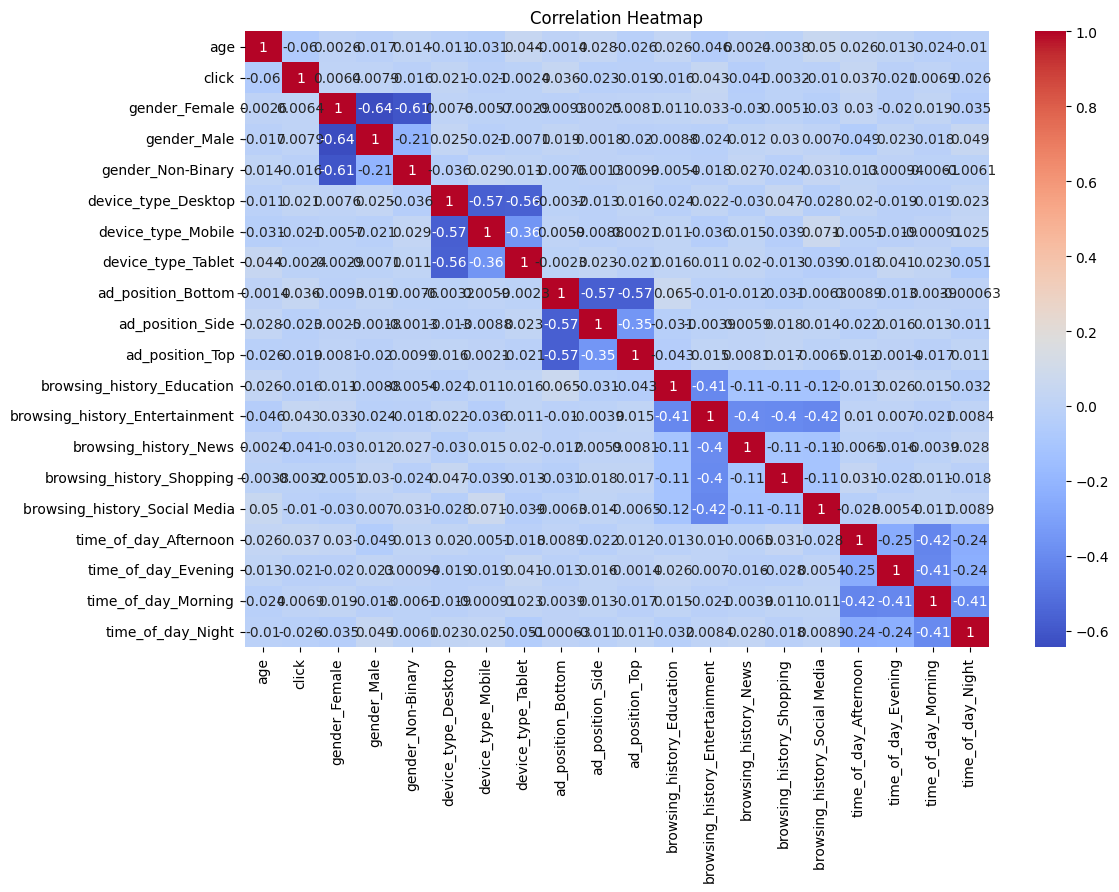

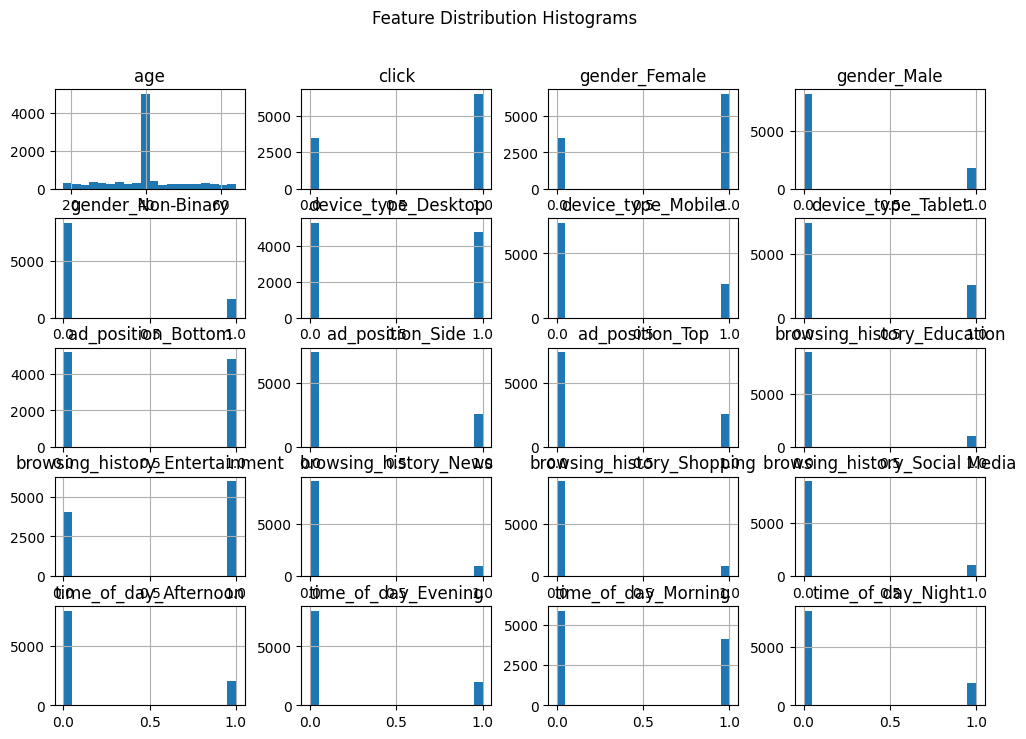

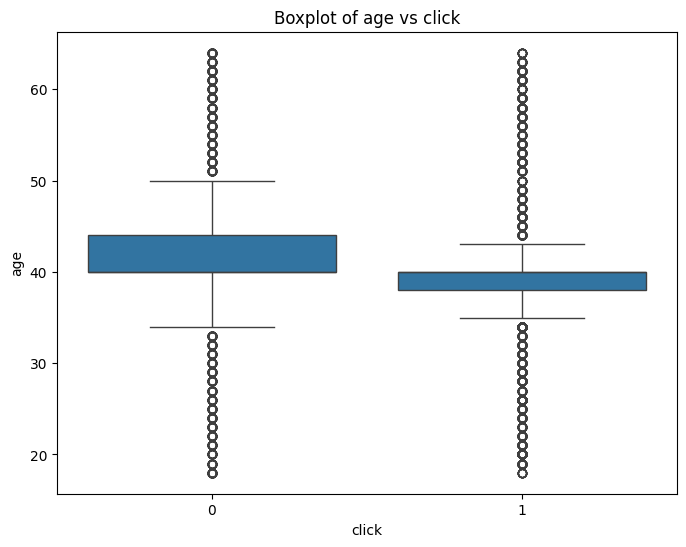

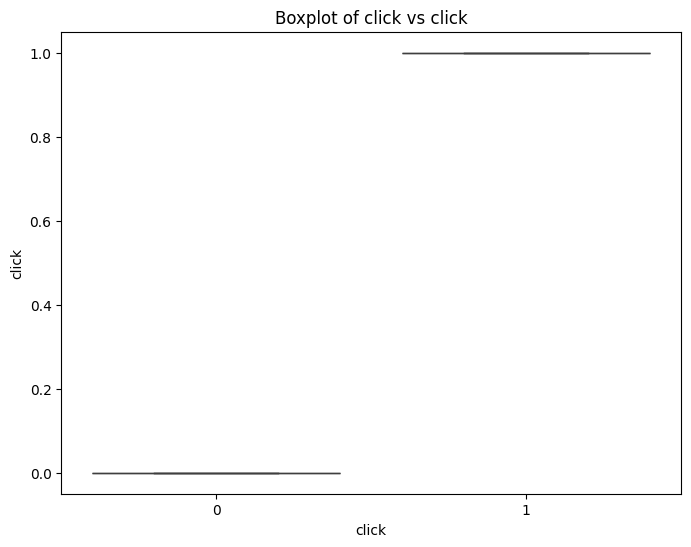

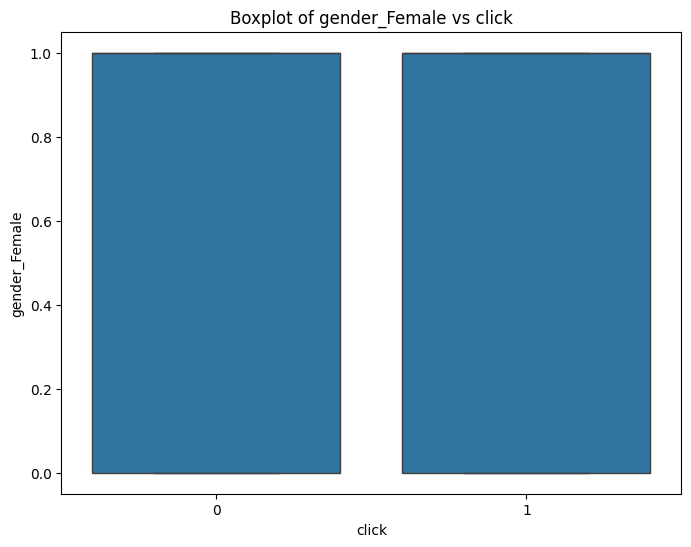

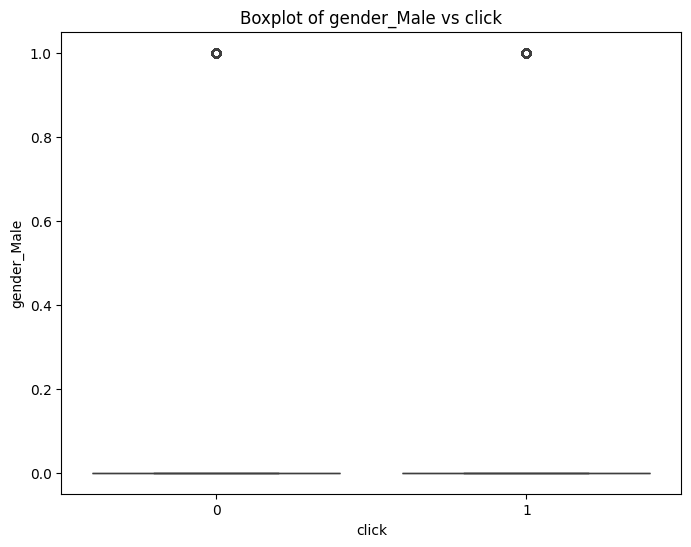

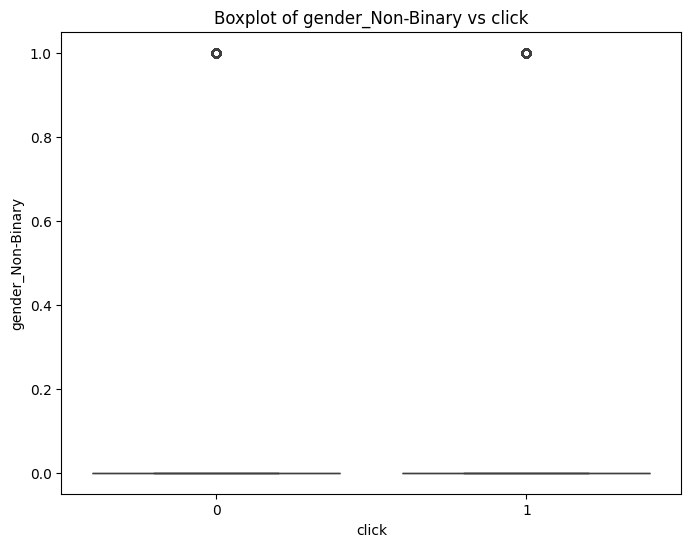

In [22]:
# 3) Visualize the data: Heatmap, Histograms, and Boxplots

# Heatmap showing correlation between numeric features
plt.figure(figsize=(12, 8))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")
plt.title('Correlation Heatmap')
plt.show()

# Histograms for the features
df.hist(figsize=(12, 8), bins=20)
plt.suptitle('Feature Distribution Histograms')
plt.show()

# Boxplots of features relative to the target variable
target = 'click'

# Select a few features to plot boxplots for
features_to_plot = df.columns[:5]
for feature in features_to_plot:
    if df[feature].dtype in ['int64', 'float64']:  # Ensure the feature is numeric
        plt.figure(figsize=(8, 6))
        sns.boxplot(x=df[target], y=df[feature])
        plt.title(f'Boxplot of {feature} vs {target}')
        plt.show()

In [23]:
# 4) Normalize the data
X = df.drop(columns=['click'])
y = df['click']

# Normalize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [24]:
# 5) Train classifiers and select optimal parameters

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

# kNN Classifier with optimal parameter tuning
knn = KNeighborsClassifier()
param_grid_knn = {'n_neighbors': [3, 5, 7, 9]}
grid_knn = GridSearchCV(knn, param_grid_knn, cv=5)
grid_knn.fit(X_train, y_train)
best_knn = grid_knn.best_estimator_
y_pred_knn = best_knn.predict(X_test)
print("Best kNN parameters:", grid_knn.best_params_)
print("kNN Classification Report:\n", classification_report(y_test, y_pred_knn))
print("kNN Confusion Matrix:\n", confusion_matrix(y_test, y_pred_knn))

# Decision Tree Classifier
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)
print("Decision Tree Classification Report:\n", classification_report(y_test, y_pred_dt))
print("Decision Tree Confusion Matrix:\n", confusion_matrix(y_test, y_pred_dt))

# SVM Classifier with GridSearchCV to select optimal 'C' and 'gamma'
svm = SVC()
param_grid_svm = {'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001]}
grid_svm = GridSearchCV(svm, param_grid_svm, cv=5)
grid_svm.fit(X_train, y_train)
best_svm = grid_svm.best_estimator_
y_pred_svm = best_svm.predict(X_test)
print("Best SVM parameters:", grid_svm.best_params_)
print("SVM Classification Report:\n", classification_report(y_test, y_pred_svm))
print("SVM Confusion Matrix:\n", confusion_matrix(y_test, y_pred_svm))

# Random Forest Classifier
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
print("Random Forest Classification Report:\n", classification_report(y_test, y_pred_rf))
print("Random Forest Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))

# AdaBoost Classifier
ada = AdaBoostClassifier(random_state=42)
ada.fit(X_train, y_train)
y_pred_ada = ada.predict(X_test)
print("AdaBoost Classification Report:\n", classification_report(y_test, y_pred_ada))
print("AdaBoost Confusion Matrix:\n", confusion_matrix(y_test, y_pred_ada))

# Compare the models to find the best
models = {'kNN': best_knn, 'Decision Tree': dt, 'SVM': best_svm, 'Random Forest': rf, 'AdaBoost': ada}
best_model = None
best_score = 0

for name, model in models.items():
    score = model.score(X_test, y_test)
    print(f'{name} Accuracy: {score}')
    if score > best_score:
        best_score = score
        best_model = model

print(f"Best Model: {best_model}")


Best kNN parameters: {'n_neighbors': 5}
kNN Classification Report:
               precision    recall  f1-score   support

           0       0.54      0.36      0.43      1055
           1       0.71      0.84      0.77      1945

    accuracy                           0.67      3000
   macro avg       0.63      0.60      0.60      3000
weighted avg       0.65      0.67      0.65      3000

kNN Confusion Matrix:
 [[ 378  677]
 [ 317 1628]]
Decision Tree Classification Report:
               precision    recall  f1-score   support

           0       0.64      0.47      0.54      1055
           1       0.75      0.86      0.80      1945

    accuracy                           0.72      3000
   macro avg       0.69      0.66      0.67      3000
weighted avg       0.71      0.72      0.71      3000

Decision Tree Confusion Matrix:
 [[ 491  564]
 [ 279 1666]]
Best SVM parameters: {'C': 100, 'gamma': 1}
SVM Classification Report:
               precision    recall  f1-score   support

   